# Based on Lab session 4 | Convolutional Neural Networks (CNN) with pytorch

pierre-henri.conze@imt-atlantique.fr \\
francois.rousseau@imt-atlantique.fr \\
sarah.reynaud@imt-atlantique.fr \\
claire.scavinner-dorval@imt-atlantique.fr

---



### 1- Data management

Start with these lines of code to automatically download the MNIST dataset.

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.ToTensor() # convert data to torch.FloatTensor

train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

In [3]:
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

batch_size = 20 # how many samples per batch to load
valid_size = 0.2 # percentage of training set to use as validation

def create_data_loaders(batch_size, valid_size, train_data, test_data):
  num_train, num_test = len(train_data), len(test_data)

  # obtain training indices that will be used for validation
  indices = list(range(num_train))
  np.random.shuffle(indices)
  split = int(np.floor(valid_size * num_train))
  train_index, valid_index = indices[split:], indices[:split]

  # define samplers for obtaining training and validation batches
  train_sampler = SubsetRandomSampler(train_index)
  valid_sampler = SubsetRandomSampler(valid_index)

  # prepare data loaders
  train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler)
  valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = valid_sampler)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)
    
  return train_loader, valid_loader, test_loader

In [4]:
train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data)

Let us visualize some images from the training set with corresponding ground truth labels.

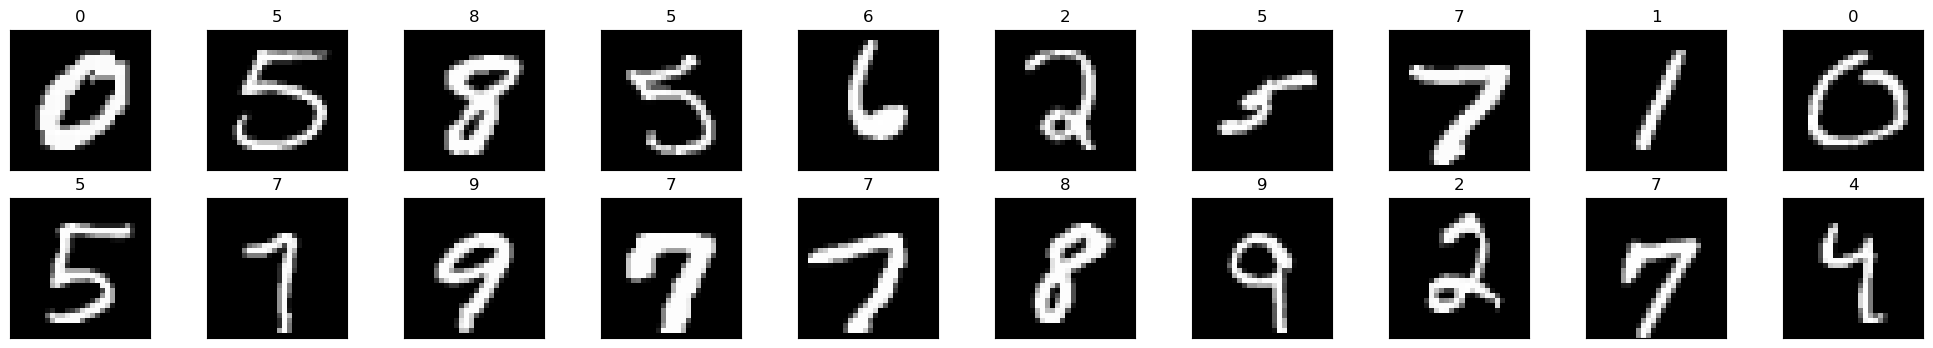

In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

images, labels = next(iter(train_loader)) # obtain one batch from the train set
images = images.numpy()
# plot images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray') # .npsqueeze removes single-dimensional entries from the shape of an array
    ax.set_title(str(labels[idx].item())) # .item() gets the value contained in a Tensor

### 2- Simple CNN architecture

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net1(nn.Module):  

    def __init__(self):
        super(Net1,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                      out_channels=32, 
                      kernel_size=3, 
                      padding=1, 
                      stride=1
            ),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, 
                      out_channels=32, 
                      kernel_size=3, 
                      padding=1, 
                      stride=1
            ),
            nn.ReLU()
        )

        self.avgplpl = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(14*14*32, 10)

        
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.avgplpl(out)
        #out = x.view(out.size(0), -1) # linear layer
        out = self.flatten(out)
        y_pred = self.fc1(out)
        return y_pred

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cuda


In [8]:
from torchsummary import summary

cnn_1 = Net1() # initialize the neural network
cnn_1.to(device=device)

summary(model=cnn_1, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 32, 28, 28]           9,248
              ReLU-4           [-1, 32, 28, 28]               0
         AvgPool2d-5           [-1, 32, 14, 14]               0
           Flatten-6                 [-1, 6272]               0
            Linear-7                   [-1, 10]          62,730
Total params: 72,298
Trainable params: 72,298
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.86
Params size (MB): 0.28
Estimated Total Size (MB): 1.14
----------------------------------------------------------------


In [9]:
# Define the loss function (criterion)
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(cnn_1.parameters(), lr=0.001)


In [10]:
n_epochs = 20 # number of epochs to train the model

def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer):

  train_losses, valid_losses = [], []
  # initialize tracker for minimum validation loss
  valid_loss_min = np.Inf  # set initial "min" to infinity

  for epoch in range(n_epochs):
      train_loss, valid_loss = 0, 0 # monitor losses
      
      # train the model
      model.train() # prep model for training
      for data, label in train_loader:
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.long)

          output = model(data) # forward pass: compute predicted outputs by passing inputs to the model
          loss = criterion(output, label) # calculate the loss
          optimizer.zero_grad() # clear the gradients of all optimized variables
          loss.backward() # backward pass: compute gradient of the loss with respect to model parameters
          optimizer.step() # perform a single optimization step (parameter update)     
          train_loss += loss.item() * data.size(0) # update running training loss
      
      # validate the model
      model.eval()
      for data, label in valid_loader:
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.long)
          with torch.no_grad():
              output = model(data)
          loss = criterion(output,label)
          valid_loss += loss.item() * data.size(0)
      
      # calculate average loss over an epoch
      train_loss /= len(train_loader.sampler)
      valid_loss /= len(valid_loader.sampler)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)
      
      print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))
      
  return train_losses, valid_losses      

In [11]:
train_losses_1, valid_losses_1 = training(n_epochs=5, train_loader=train_loader, valid_loader=valid_loader, model=cnn_1, criterion=criterion, optimizer=optimizer)

epoch: 1 	training Loss: 0.162453 	validation Loss: 0.078425
epoch: 2 	training Loss: 0.062387 	validation Loss: 0.060389
epoch: 3 	training Loss: 0.043073 	validation Loss: 0.055286
epoch: 4 	training Loss: 0.031905 	validation Loss: 0.051070
epoch: 5 	training Loss: 0.024548 	validation Loss: 0.053892


### 4- Testing

In [12]:
def evaluation(model, test_loader, criterion):

  # initialize lists to monitor test loss and accuracy
  test_loss = 0.0
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))

  model.eval() # prep model for evaluation
  for data, label in test_loader:
      data = data.to(device=device, dtype=torch.float32)
      label = label.to(device=device, dtype=torch.long)
      with torch.no_grad():
          output = model(data) # forward pass: compute predicted outputs by passing inputs to the model
      loss = criterion(output, label)
    
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1) # convert output probabilities to predicted class
      correct = np.squeeze(pred.eq(label.data.view_as(pred))) # compare predictions to true label
      # calculate test accuracy for each object class
      for i in range(len(label)):
          digit = label.data[i]
          class_correct[digit] += correct[i].item()
          class_total[digit] += 1

  # calculate and print avg test loss
  test_loss = test_loss/len(test_loader.sampler)
  print('test Loss: {:.6f}\n'.format(test_loss))
  for i in range(10):
      print('test accuracy of %1s: %2d%% (%2d/%2d)' % (str(i), 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
  print('\ntest accuracy (overall): %2.2f%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

In [13]:
evaluation(cnn_1, test_loader, criterion) 

test Loss: 0.040954

test accuracy of 0: 99% (974/980)
test accuracy of 1: 99% (1130/1135)
test accuracy of 2: 98% (1014/1032)
test accuracy of 3: 98% (995/1010)
test accuracy of 4: 99% (981/982)
test accuracy of 5: 98% (882/892)
test accuracy of 6: 97% (938/958)
test accuracy of 7: 98% (1009/1028)
test accuracy of 8: 98% (962/974)
test accuracy of 9: 96% (978/1009)

test accuracy (overall): 98.63% (9863/10000)


### 5- Assessment

The following cell displays test images and their labels in this format: predicted (ground-truth). The text will be green for accurately classified examples and red for incorrect predictions.

In [14]:
def visualization(model, test_loader):
  images, labels = next(iter(test_loader)) # obtain one batch of test images
  images = images.to(device=device, dtype=torch.float32)
  labels = labels.to(device=device, dtype=torch.long)
  with torch.no_grad():
      output = model(images) # get model output
  _, preds = torch.max(output, 1) # convert output probabilities to predicted class
  images = images.cpu().numpy() # prep images for display
  # plot the images in the batch, along with predicted and true labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(20):
      ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(images[idx]), cmap='gray')
      ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))

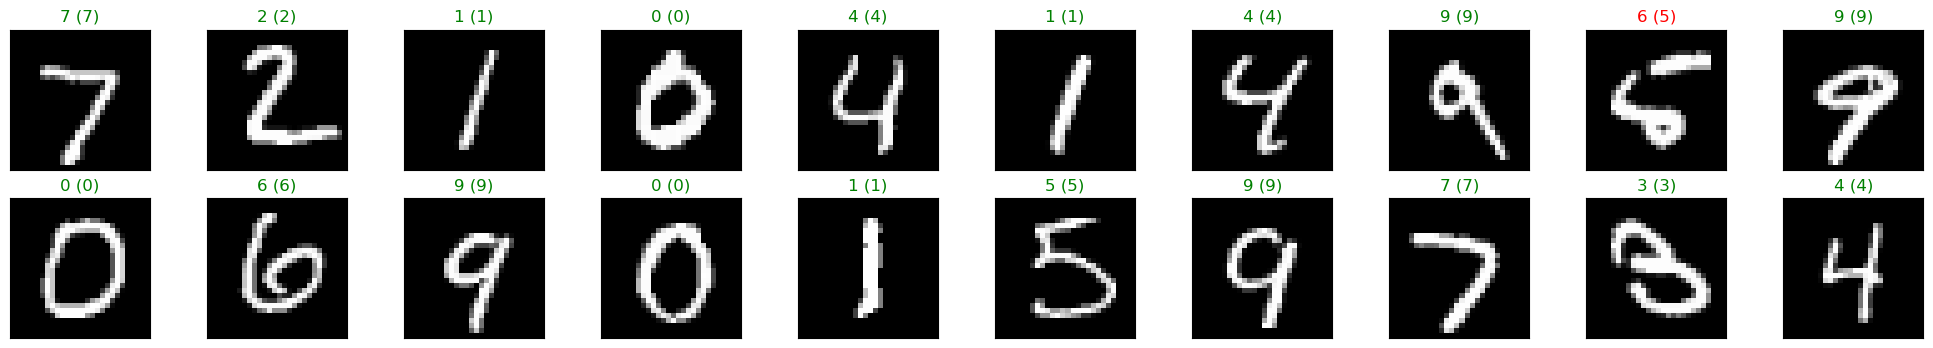

In [15]:
visualization(cnn_1, test_loader)

Let us extract predicted (*preds*) and ground truth (*targets*) labels for images arising from the test set.

In [16]:
def get_all_prediction(model, loader):
    preds = torch.tensor([], dtype=torch.long)
    targets = torch.tensor([], dtype=torch.long)
    for data, label in loader:
        data = data.to(device=device, dtype=torch.float32)
        label = label.to(device=device, dtype=torch.long)
        with torch.no_grad():
            output = model(data)
        targets = torch.cat((targets, label.cpu()), dim = 0)
        preds = torch.cat((preds, torch.max(output.cpu(), 1)[1]), dim = 0)
    return targets.numpy(), preds.numpy()

In [17]:
targets, preds_1 = get_all_prediction(cnn_1, test_loader)

### 6- **CAM** - Visualization.

<Figure size 2500x400 with 0 Axes>

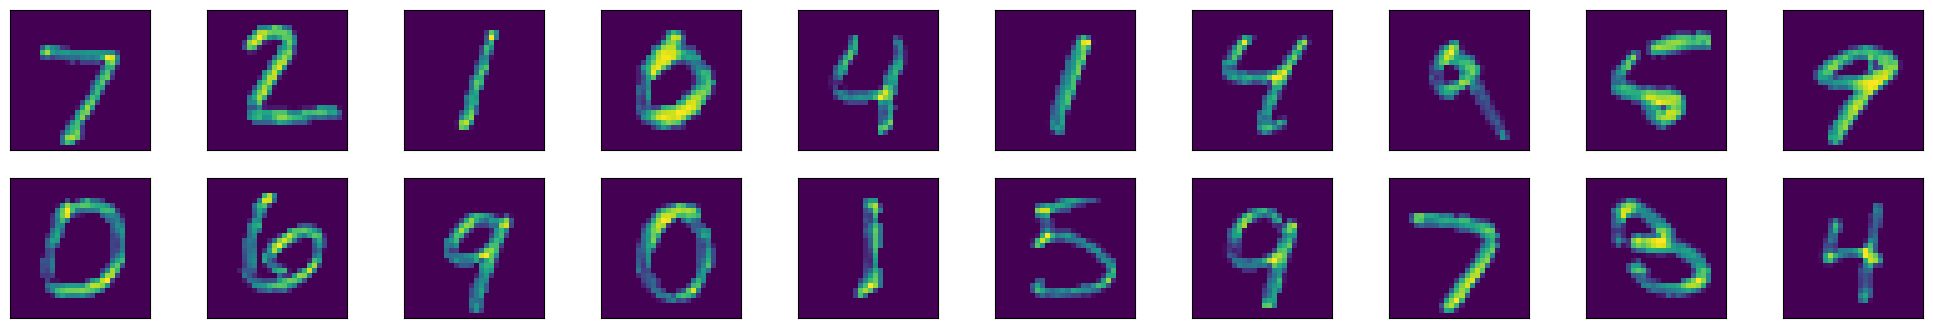

In [35]:
from captum.attr import LayerGradCam, IntegratedGradients


cnn_1.eval()

# chooses image
fig = plt.figure(figsize=(25, 4))
images, labels = next(iter(test_loader)) # obtain one batch of test
images = images.to(device=device)

# calculate gradient of the image 
target_layer = cnn_1.conv2[-1]
ig = LayerGradCam(cnn_1, target_layer)
attributions = ig.attribute(images, target=0)

# draw CAM
attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())
cam = attributions.unsqueeze(0).unsqueeze(0) * images
cam_cpu = cam.cpu()
cam_image = cam_cpu.squeeze(0).squeeze(0).detach().numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(cam_image[idx]))
